In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Fri Jun 24 00:46:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 28%   37C    P8    22W / 260W |   3450MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   

# LDA

## 2015 brief paragraph

In [3]:
file_us = open("../LDA/segment/data/us_file_brief_paragraph_2015.txt", "r")
us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(us_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(5060 unique tokens: ['allocate', 'apparatus', 'base', 'calculate', 'communication']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in us_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 2), (3, 2), (4, 2), (5, 2), (6, 3), (7, 2), (8, 1), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-6.542807,694.232746
1,3,-6.555507,703.105793
2,4,-6.541806,693.537668
3,5,-6.538294,691.106328
4,6,-6.523260,680.793999
5,7,-6.517758,677.058706
6,8,-6.520771,679.101796
7,9,-6.524391,681.564354
8,10,-6.513009,673.850694
9,11,-6.515295,675.393061


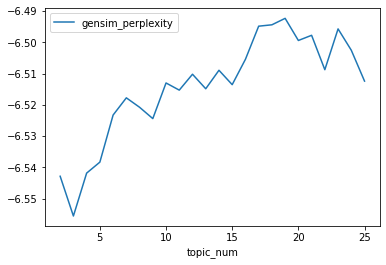

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-6.542807,694.232746
1,3,-6.555507,703.105793
2,4,-6.541806,693.537668
3,5,-6.538294,691.106328
4,6,-6.523260,680.793999
5,7,-6.517758,677.058706
6,8,-6.520771,679.101796
7,9,-6.524391,681.564354
8,10,-6.513009,673.850694
9,11,-6.515295,675.393061


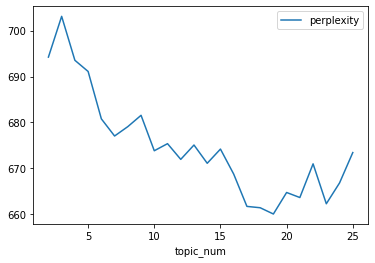

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_us_brief_paragraph_2015.csv", index=False)

## priority description sentence

In [11]:
# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(us_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in us_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_us_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

5

In [23]:
topics_us = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_us.append(c.index(max(c)))

In [24]:
topics_us

[5,
 6,
 7,
 6,
 14,
 15,
 5,
 12,
 18,
 16,
 12,
 16,
 6,
 7,
 7,
 5,
 11,
 4,
 2,
 5,
 12,
 14,
 1,
 3,
 4,
 5,
 14,
 11,
 16,
 5,
 3,
 9,
 5,
 3,
 16,
 2,
 6,
 6,
 6,
 5,
 6,
 4,
 12,
 6,
 11,
 15,
 2,
 7,
 7,
 7,
 9,
 11,
 3,
 2,
 5,
 5,
 16,
 8,
 1,
 5,
 3,
 3,
 15,
 8,
 6,
 6,
 11,
 2,
 6,
 16,
 15,
 5,
 6,
 6,
 2,
 10,
 6,
 6,
 12,
 1,
 6,
 16,
 6,
 16,
 17,
 6,
 6,
 2,
 6,
 7,
 6,
 2,
 5,
 7,
 6,
 6,
 2,
 16,
 8,
 6,
 6,
 8,
 16,
 7,
 17,
 6,
 6,
 16,
 16,
 6,
 4,
 6,
 13,
 16,
 3,
 16,
 15,
 12,
 6,
 4,
 13,
 2,
 7,
 11,
 12,
 2,
 1,
 11,
 5,
 4,
 5,
 16,
 12,
 10,
 12,
 8,
 5,
 6,
 16,
 3,
 7,
 16,
 3,
 11,
 7,
 3,
 11,
 6,
 3,
 5,
 1,
 11,
 2,
 1,
 16,
 1,
 14,
 10,
 3,
 0,
 3,
 16,
 3,
 16,
 3,
 2,
 5,
 16,
 2,
 16,
 2,
 12,
 16,
 7,
 11,
 8,
 17,
 14,
 1,
 6,
 2,
 13,
 3,
 1,
 3,
 15,
 6,
 2,
 6,
 0,
 3,
 8,
 6,
 6,
 9,
 2,
 3,
 3,
 16,
 1,
 2,
 3,
 6,
 12,
 1,
 5,
 16,
 11,
 15,
 8,
 16,
 3,
 5,
 11,
 14,
 8,
 5,
 16,
 15,
 9,
 1,
 1,
 4,
 6,
 14,
 6,
 1,
 6,
 16,
 15,
 1

In [25]:
print(len(topics_us))
print(len(us_desc))

2001
2001


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_us = db.rm_patent_us
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2015 = db.rm_patent_us_2015
    db_rm_us_2015 = db.rm_patent_us_2015
    # db_rm_de_2015 = db.rm_patent_de_2015
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_us_desc = p_db_us.find({}, {"patentNumber":1, "brief": 1})
data_us_desc = db_rm_us_2015.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_us_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_us

,id,patentNumber,company,brief
0,62009ffc7b73c16636b310c4,US9451555B2,[InterDigital Patent Holdings Inc],Method and apparatus for controlling a transmi...
1,6200a1bf7b73c16636b310dc,US9179421B2,[Qualcomm Inc],Methods and apparatuses are provided for deter...
2,6200b3407b73c16636b31116,US20160029209A1,[Samsung Electronics Co Ltd],A system and a method that reports capability ...
3,6200b45e7b73c16636b31126,US10104180B2,[IoT Holdings Inc],Systems and/or methods for providing internetw...
4,6200b5777b73c16636b31138,US20160007139A1,[IoT Holdings Inc],Methods and apparatus are provided for perform...
...,...,...,...,...
1996,6205f839491d89397b84c79e,US20180302387A1,[Telefonaktiebolaget LM Ericsson AB],A method performed by a computing device of es...
1997,6205f83c491d89397b84c7a0,US20170346832A1,[NEC Corp],"According to one embodiment, an authentication..."
1998,6205f83d491d89397b84c7a2,US9836387B1,[Marvell Asia Pte Ltd],Systems and methods are provided for debugging...
1999,6205f84b491d89397b84c7a8,US20180299847A1,[NEC Corp],None


In [30]:
print(len(df_us))
print(len(us_desc))

2001
2001


In [31]:
df_us["topic"]=topics_us

In [32]:
df_us

,id,patentNumber,company,brief,topic
0,62009ffc7b73c16636b310c4,US9451555B2,[InterDigital Patent Holdings Inc],Method and apparatus for controlling a transmi...,5
1,6200a1bf7b73c16636b310dc,US9179421B2,[Qualcomm Inc],Methods and apparatuses are provided for deter...,6
2,6200b3407b73c16636b31116,US20160029209A1,[Samsung Electronics Co Ltd],A system and a method that reports capability ...,7
3,6200b45e7b73c16636b31126,US10104180B2,[IoT Holdings Inc],Systems and/or methods for providing internetw...,6
4,6200b5777b73c16636b31138,US20160007139A1,[IoT Holdings Inc],Methods and apparatus are provided for perform...,14
...,...,...,...,...,...
1996,6205f839491d89397b84c79e,US20180302387A1,[Telefonaktiebolaget LM Ericsson AB],A method performed by a computing device of es...,16
1997,6205f83c491d89397b84c7a0,US20170346832A1,[NEC Corp],"According to one embodiment, an authentication...",16
1998,6205f83d491d89397b84c7a2,US9836387B1,[Marvell Asia Pte Ltd],Systems and methods are provided for debugging...,4
1999,6205f84b491d89397b84c7a8,US20180299847A1,[NEC Corp],None,11


In [33]:
df_us2 = df_us.explode('company')
df_us2

,id,patentNumber,company,brief,topic
0,62009ffc7b73c16636b310c4,US9451555B2,InterDigital Patent Holdings Inc,Method and apparatus for controlling a transmi...,5
1,6200a1bf7b73c16636b310dc,US9179421B2,Qualcomm Inc,Methods and apparatuses are provided for deter...,6
2,6200b3407b73c16636b31116,US20160029209A1,Samsung Electronics Co Ltd,A system and a method that reports capability ...,7
3,6200b45e7b73c16636b31126,US10104180B2,IoT Holdings Inc,Systems and/or methods for providing internetw...,6
4,6200b5777b73c16636b31138,US20160007139A1,IoT Holdings Inc,Methods and apparatus are provided for perform...,14
...,...,...,...,...,...
1996,6205f839491d89397b84c79e,US20180302387A1,Telefonaktiebolaget LM Ericsson AB,A method performed by a computing device of es...,16
1997,6205f83c491d89397b84c7a0,US20170346832A1,NEC Corp,"According to one embodiment, an authentication...",16
1998,6205f83d491d89397b84c7a2,US9836387B1,Marvell Asia Pte Ltd,Systems and methods are provided for debugging...,4
1999,6205f84b491d89397b84c7a8,US20180299847A1,NEC Corp,None,11


In [34]:
# 排名前16的公司
c_ls = list(df_us2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Samsung Electronics Co Ltd',
 'Intel Corp',
 'Telefonaktiebolaget LM Ericsson AB',
 'Qualcomm Inc',
 'Cisco Technology Inc',
 'Afero Inc',
 'International Business Machines Corp',
 'Microsoft Technology Licensing LLC',
 'Convida Wireless LLC',
 'Apple Inc',
 'Nokia Solutions and Networks Oy',
 'Verizon Patent and Licensing Inc',
 'Electronics and Telecommunications Research Institute ETRI',
 'LG Electronics Inc',
 'Nokia Technologies Oy',
 'Intel IP Corp']

### 轉成company-topic 的總數表格

In [35]:
df_us_count = df_us2.groupby(["company","topic"],as_index=False).size()
df_us_count

,company,topic,size
0,3d-Oxides,2,1
1,ABB Schweiz AG,2,1
2,ABB Schweiz AG,3,1
3,ALLIACENSE Ltd LLC,2,1
4,APPSFREEDOM Inc,10,1
...,...,...,...
949,Yuan Ze University,10,1
950,ZTE Corp,2,1
951,ZTE Corp,16,1
952,Zhejiang Shenghui Lighting Co Ltd,1,1


In [36]:
# 轉成company-topic 的總數表格
table_us = df_us_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_us = table_us.droplevel(level=0, axis=1)
table_us = table_us.rename(columns={'':'company'})

In [37]:
table_us

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3d-Oxides,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABB Schweiz AG,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ALLIACENSE Ltd LLC,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,APPSFREEDOM Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ARM Ltd,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,Yonomi Inc,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
472,Yuan Ze University,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
473,ZTE Corp,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
474,Zhejiang Shenghui Lighting Co Ltd,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
final_table_us = table_us[table_us.company.isin(c_ls)]
final_table_us

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
21,Afero Inc,0.0,0.0,2.0,28.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,6.0,4.0,0.0,0.0
35,Apple Inc,0.0,1.0,0.0,0.0,1.0,4.0,2.0,1.0,8.0,0.0,2.0,1.0,5.0,2.0,2.0,2.0,1.0,0.0,0.0
89,Cisco Technology Inc,1.0,5.0,1.0,2.0,2.0,3.0,5.0,2.0,2.0,3.0,0.0,0.0,0.0,2.0,1.0,6.0,13.0,1.0,1.0
93,Convida Wireless LLC,0.0,2.0,2.0,1.0,1.0,1.0,2.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,5.0,2.0,11.0,0.0,1.0
126,Electronics and Telecommunications Research In...,1.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0,1.0,3.0,0.0,2.0,2.0,2.0,0.0,1.0,5.0,0.0,0.0
203,Intel Corp,1.0,40.0,17.0,5.0,14.0,14.0,25.0,3.0,31.0,7.0,7.0,11.0,21.0,6.0,17.0,6.0,29.0,5.0,1.0
206,Intel IP Corp,1.0,3.0,0.0,1.0,1.0,0.0,3.0,2.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
211,International Business Machines Corp,0.0,9.0,9.0,0.0,0.0,1.0,4.0,2.0,1.0,4.0,2.0,0.0,1.0,1.0,3.0,0.0,6.0,1.0,2.0
244,LG Electronics Inc,1.0,1.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,0.0,2.0,0.0,7.0,1.0,0.0,2.0,3.0,0.0,0.0
281,Microsoft Technology Licensing LLC,0.0,3.0,6.0,3.0,4.0,4.0,3.0,1.0,2.0,0.0,1.0,2.0,2.0,0.0,0.0,1.0,9.0,2.0,2.0


In [39]:
final_table_us.shape

(16, 20)

In [40]:
table_us.to_csv('company_lda_brief_us_2015.csv',index=0)